Aim: to compare readings from HR strap from Garmin strap vs optical HR from Garmin Forerunner 35

In [28]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xml.etree.ElementTree as ET
import datetime

In [29]:
%matplotlib inline

In [30]:
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['font.size'] = 14

In [33]:
def trackpoint_to_dict(tp):
    """Save interesting info from Trackpoint element as dict"""
    return {
        'time': tp.find('g:Time', ns).text,
        'hr': int(tp.find('g:HeartRateBpm/g:Value', ns).text)
    }

In [34]:
def tcx_to_dataframe(tcx_filename):
    """Open TCX file, pull info for each trackpoint in time.
    Returns info as pandas Dataframe
    """
    tree = ET.parse(tcx_filename)
    root = tree.getroot()
    ns = {"g": "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2"}  # garmin namespace, bleurgh
    trackpoints = root.findall(".//g:Trackpoint", ns)
    dicts = [trackpoint_to_dict(tp) for tp in trackpoints] 
    df = pd.DataFrame(dicts)
    df['time'] = pd.to_datetime(df['time'])#.dt.time  # only use time
    return df

In [35]:
df_strap = tcx_to_dataframe("strap.tcx")

In [36]:
df_watch = tcx_to_dataframe("watch.tcx")

In [37]:
# Convert to time from start of activity
start_time = min(df_strap.time[0], df_watch.time[0])
df_watch['rel_time'] = df_watch.time - start_time
df_strap['rel_time'] = df_strap.time - start_time

In [38]:
df_strap.dtypes

hr                    int64
time         datetime64[ns]
rel_time    timedelta64[ns]
dtype: object

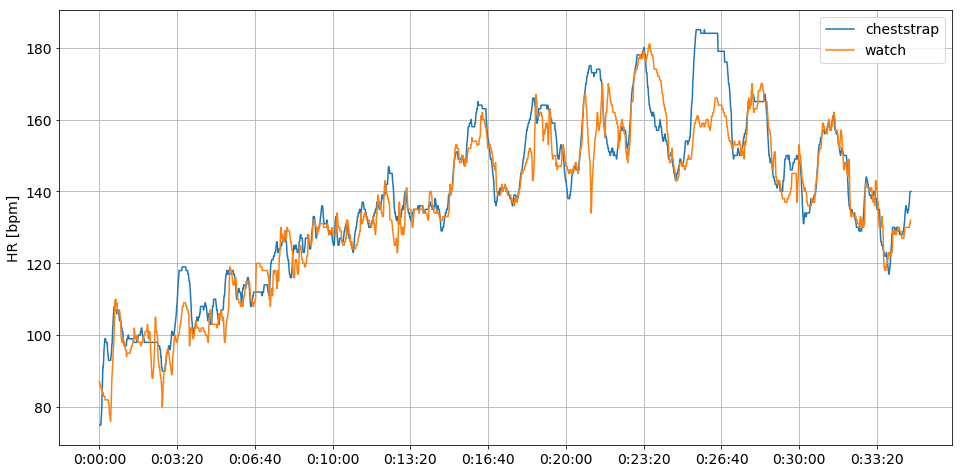

In [39]:
plt.plot(df_strap.rel_time, df_strap.hr, label='cheststrap');
ax = plt.gca()
ax.plot(df_watch.rel_time, df_watch.hr, label='watch');
plt.legend(loc='best');
plt.ylabel('HR [bpm]');

ml = ax.xaxis.get_major_locator()
ml.set_params(nbins=20, min_n_ticks=10)
ax.xaxis.set_major_locator(ml)

# This doesn't work for timedelta, no idea why
# locator = mdates.AutoDateLocator()
# ax.xaxis.set_major_locator(locator)

def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(seconds=x/1E9)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = mpl.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.xaxis.set_major_formatter(formatter)  

plt.grid();